In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
from pymannkendall import original_test
from scipy.stats import entropy
from cmcrameri import cm
import cartopy.feature as cf
import regionmask

In [2]:
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 18})
regions_list = ['Western', 'Northern', 'Southern', 'Eastern']
regions_replace = { 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'}
wong = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#999999']
wong_b = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']
hue_order = datasets_names.copy()
hue_order.append('Stations')
legend_elements = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong[i], markersize=12) for i in range(len(wong))]
legend_elements_b = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong_b[i], markersize=12) for i in range(len(wong_b))]
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')

In [32]:
from distributed import Client
client = Client(n_workers=4, threads_per_worker=1) 
from scipy import stats as st
#Standardized Precipitation Index Function
def spi(ds, thresh, dimension):
    #ds - data ; thresh - time interval / scale; dimension - dimension as a string
    
    #Rolling Mean / Moving Averages
    ds_ma = ds.rolling(time = thresh, center=False).mean()
    
    #Natural log of moving averages
    ds_In = np.log(ds_ma)
    ds_In = ds_In.where(np.isinf(ds_In) == False) #= np.nan  #Change infinity to NaN
    ds_mu = ds_ma.mean(dimension)
    #Overall Mean of Moving Averages
    ds_mu = ds_ma.mean(dimension)

    #Summation of Natural log of moving averages
    ds_sum = ds_In.sum(dimension)
    
    #Computing essentials for gamma distribution
    n = ds_In[thresh-1:, :, :].count(dimension)                  #size of data
    A = np.log(ds_mu) - (ds_sum/n)             #Computing A
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
    beta = ds_mu/alpha                         #Computing beta (scale)
    
    #Gamma Distribution (CDF) 
    gamma_func = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)
    gamma = xr.apply_ufunc(gamma_func, ds_ma, alpha, beta)
    
    #Standardized Precipitation Index   (Inverse of CDF)
    norminv = lambda data: st.norm.ppf(data, loc=0, scale=1)
    norm_spi = xr.apply_ufunc(norminv, gamma)  #loc is mean and scale is standard dev.
    
    return ds_ma, ds_In , ds_mu, ds_sum,n, A, alpha, beta, gamma, norm_spi

In [3]:
stations = gpd.read_file(r'Data\Evaluation\stations_amz_ANA.geojson')
df_stat= pd.read_pickle(r'Data\Evaluation\amz_01_20_20bet.pkl')
df_month = df_stat.groupby(['Code',df_stat.Date.dt.month]).mean().reset_index()
df_stat.sort_values(by=['Code','Date'], inplace=True)
df_stat['SPI12'] = df_stat.groupby('Code')['Total'].rolling(12, center=False).mean().reset_index(0,drop=True)

C:\Users\luisg\AppData\Local\Temp\ipykernel_4692\1313474849.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month = df_stat.groupby(['Code',df_stat.Date.dt.month]).mean().reset_index()


In [33]:
folder_metric = r'Data\Datasets\amz\ts'

ds = xr.open_dataset(os.path.join(folder_metric, 'cru' + '.nc'))
ds_spi12 = spi(ds.pr,12,'time')

In [58]:
ds_In = np.log(df_stat['SPI12'])
df_stat['SPI12']= ds_In.where(np.isinf(ds_In) == False)
ds_mu = df_stat.groupby('Code')['SPI12'].mean()

#Summation of Natural log of moving averages
ds_sum = df_stat.groupby('Code')['SPI12'].sum()

#Computing essentials for gamma distribution
n = df_stat.groupby('Code')['SPI12'].count()                  #size of data
A = np.log(ds_mu) - (ds_sum/n)             #Computing A
alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
beta = ds_mu/alpha                         #Computing beta (scale)

#Gamma Distribution (CDF)
gamma_func = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)
gamma = df_stat.groupby(['Code'])['SPI12'].apply(gamma_func, alpha, beta)

ValueError: operands could not be broadcast together with shapes (240,) (581,) 

In [62]:
st.gamma.cdf(df_stat['SPI12'], alpha, scale=beta)

ValueError: operands could not be broadcast together with shapes (139440,) (581,) 

In [23]:
#mininum value for SPI in 2015-2016 each code
df1516 = df_stat[(df_stat.Date.dt.year >= 2015) & (df_stat.Date.dt.year <= 2016)]
df1516 = df1516.groupby('Code').min().reset_index()


In [4]:
ds_spi = {}
folder_metric = r'Data\Datasets\amz\ts'
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    ds_spi12 = spi(ds.pr,12,'time')[9].to_dataset(name='SPI12')
    mask = regions_mask.mask(ds_spi12, lon_name='lon', lat_name='lat')
    ds_spi12['Region'] = mask
    ds_spi[datasets_names[i]] = ds_spi12
    print(datasets_names[i])

CRU
GPCC
CHIRPS


c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


IMERG-V6
TerraClimate


c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


ERA5-Land
JRA55
MERRA2


C:\Users\luisg\AppData\Local\Temp\ipykernel_2660\1579232208.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


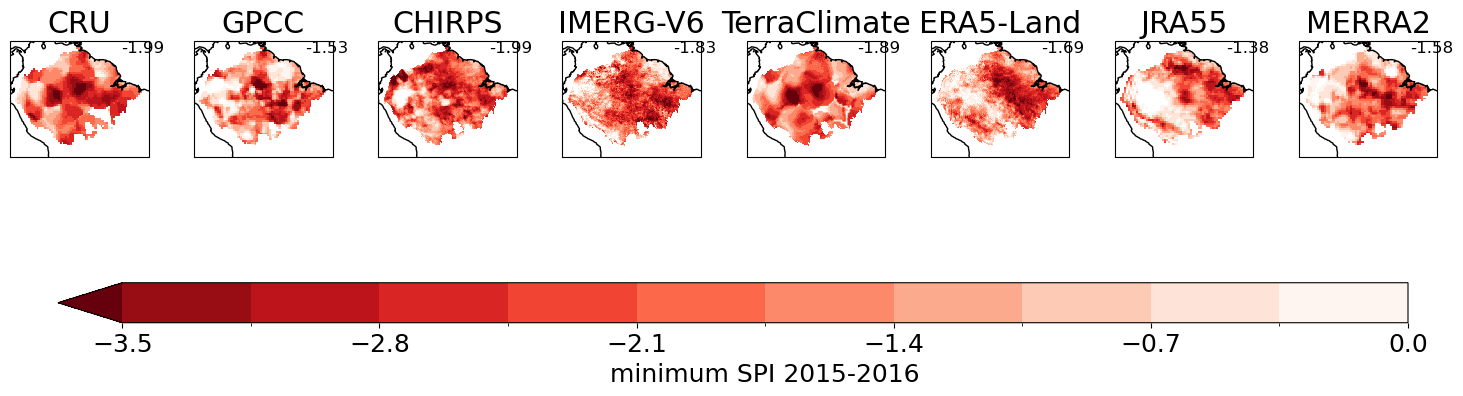

In [22]:
#create a dictionary withh all datasets
vmin = -3.5
vmax = 0
levels = 11
proj = ccrs.Mercator()
extend = [-81, -42, -20, 11]
cmap = mpl.cm.Reds_r
bounds = np.linspace(vmin,vmax, levels)
extend_cmap = 'min'
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend=extend_cmap )
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

# Create a figure and a gridspec layout
fig, axes = plt.subplots(ncols=len(datasets_names), nrows=1, figsize=(15, 4), subplot_kw={'projection': proj})
#color bar
cax = fig.add_axes([0.05, -0.06, 0.9, 0.1])
fig.colorbar(sm, cax=cax, orientation='horizontal', label='minimum SPI 2015-2016')
# Loop through the datasets and plot them
for i, name in enumerate(datasets_names):
    # Create an axis for the subplot
    ds = ds_spi[name]['SPI12'].where(np.isinf(ds_spi[name]['SPI12']) == False).sel(time=slice('2015', '2016')).min(dim='time')
    im = ds.plot(ax=axes[i], cmap=cmap,vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), levels= levels, extend=extend_cmap )
    axes[i].set_title(name)
    #axes[i].add_geometries(shp_pan.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_extent(extend)
    axes[i].coastlines()
    #annotate in the top right corner the mean of ds
    axes[i].annotate(str(ds.mean().values.round(2)), xy=(0.80, 0.9), xycoords='axes fraction', fontsize=12)

plt.tight_layout()

In [15]:
df = pd.DataFrame()
for name in datasets_names:
    ds = ds_spi[name].groupby('Region').mean()
    dff =  ds.to_dataframe().dropna().reset_index()
    dff['Dataset'] = name
    dff['Region'] = dff['Region'].replace(regions_replace)
    df = df.append(dff)
df = df[['SPI12', 'Region', 'Dataset','time']].dropna().reset_index(drop=True)
#fix time, Y-M-D
df['time'] = df['time'].astype(str)
df['time'] = df['time'].str.split('-', expand=True)[0] + '-' + df['time'].str.split('-', expand=True)[1]
df['time'] = pd.to_datetime(df['time'], format='%Y-%m')
df


C:\Users\luisg\AppData\Local\Temp\ipykernel_2660\554452294.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2660\554452294.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2660\554452294.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2660\554452294.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2660\554452294.py:7: FutureWarning: The frame.append method is deprecated an

,SPI12,Region,Dataset,time
0,0.410768,Southern,CRU,2001-12-01
1,0.074695,Southern,CRU,2002-01-01
2,0.299082,Southern,CRU,2002-02-01
3,0.278139,Southern,CRU,2002-03-01
4,0.419963,Southern,CRU,2002-04-01
...,...,...,...,...
7323,-0.187086,Northern,MERRA2,2020-08-01
7324,-0.172863,Northern,MERRA2,2020-09-01
7325,-0.236793,Northern,MERRA2,2020-10-01
7326,-0.164129,Northern,MERRA2,2020-11-01


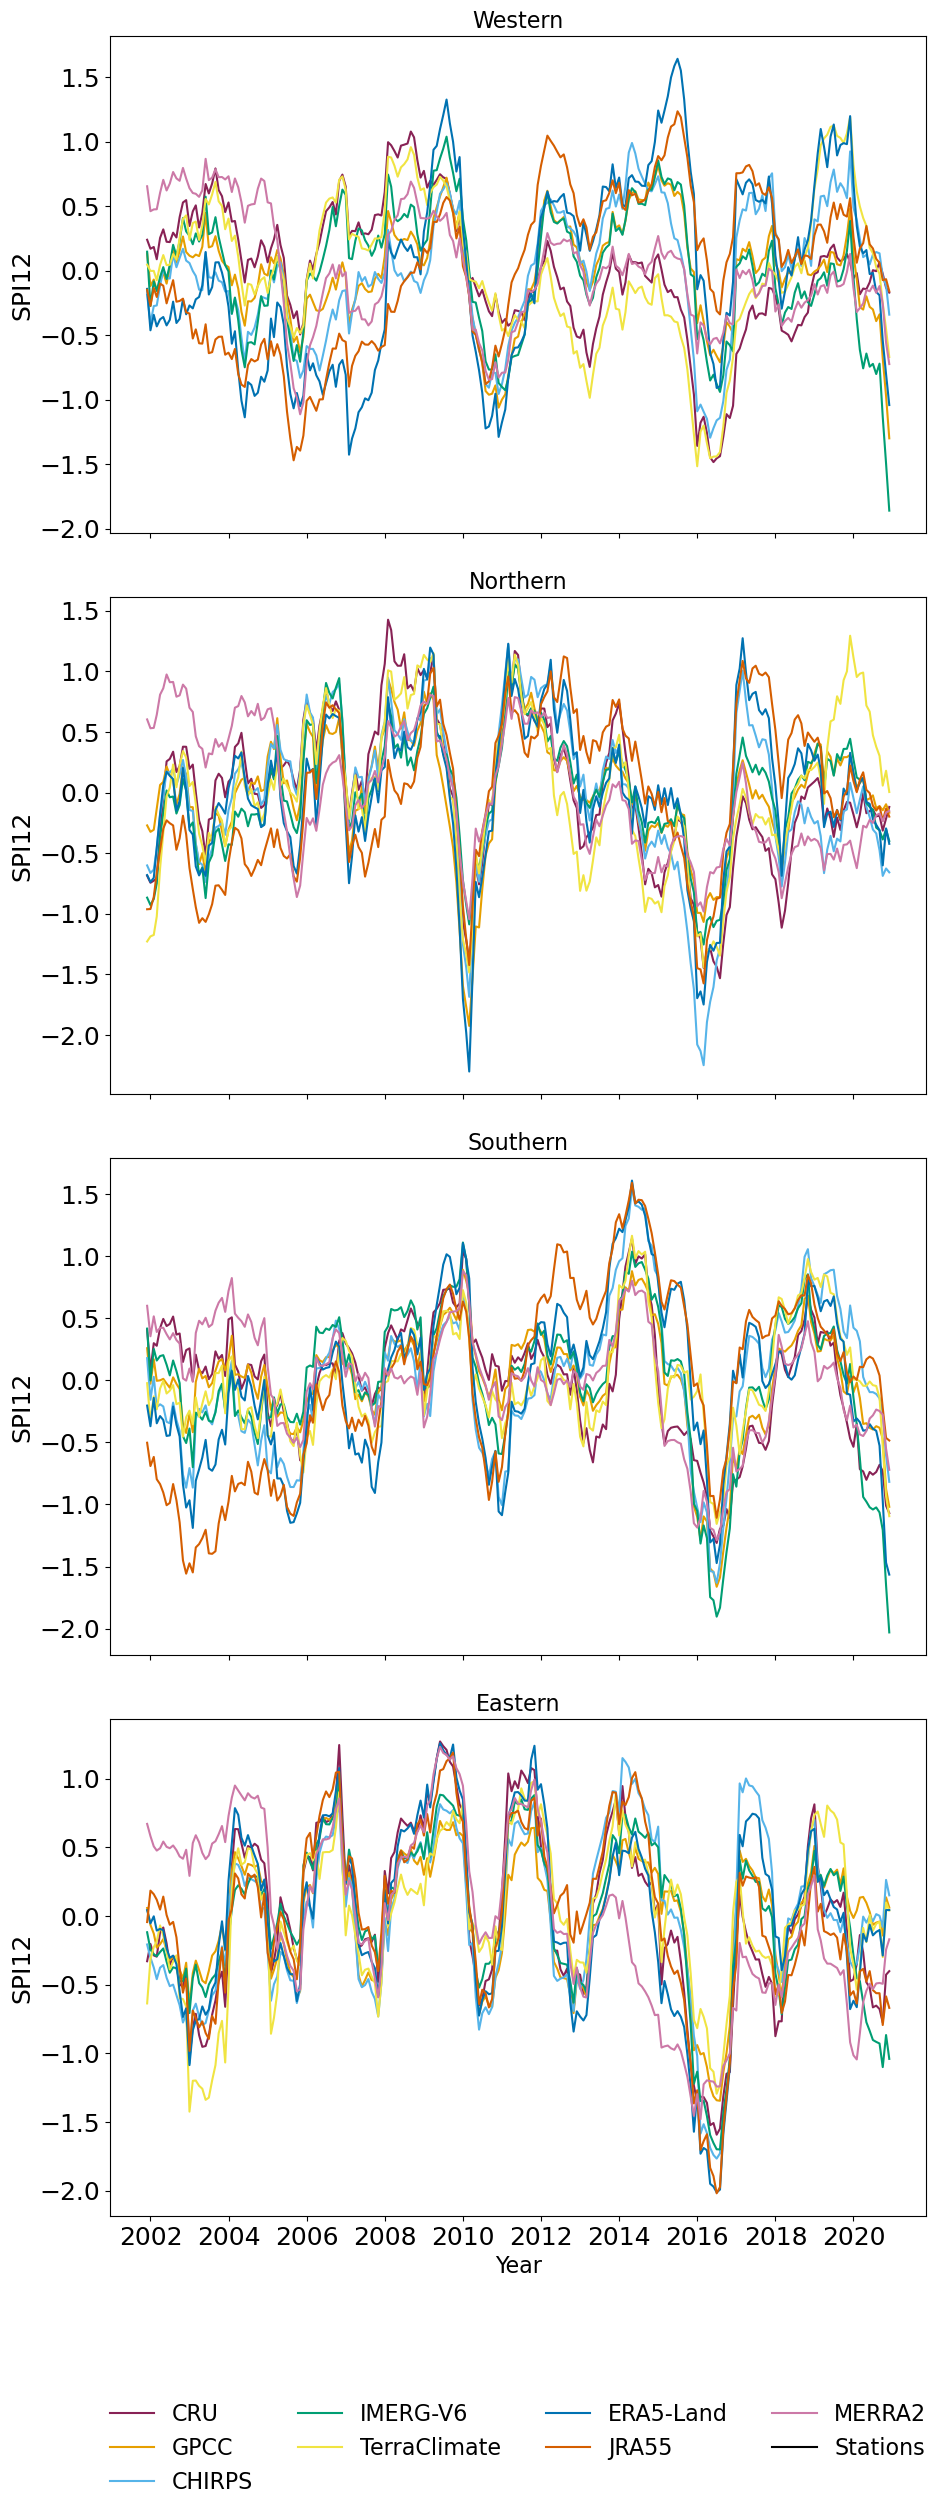

In [20]:

#a lineplot for each region
fig, axes = plt.subplots(4,1, figsize=(10, 25), sharex=True)
axes = axes.flatten()
for i, region in enumerate(regions_list):
    sns.lineplot(data=df[df.Region==region], x='time', y='SPI12', hue='Dataset', ax=axes[i], palette=wong_b, hue_order=hue_order, legend=True)
    axes[i].set_title(region, fontsize=16)
    #axes[i].set_ylabel('Seasonal Precipitation (mm/month)', fontsize=16)
    axes[i].set_xlabel('Year', fontsize=16)
    #axes[i].text(0.06,0.96,  letters_ts[i], transform=axes[i].transAxes,  fontsize=20, va='top', ha='right')
    #axes[i].set_xticks([2001, 2005,2010, 2015, 2020])
    if i != 3:
        axes[i].get_legend().remove()

#put legend outside the plot
axes[3].legend(bbox_to_anchor=(0.5, -0.6), loc='lower center', ncol=4, frameon=False, fontsize=16)
plt.tight_layout()

In [23]:
df = pd.DataFrame()
for name in datasets_names:
    ds = ds_spi[name].sel(time=slice('2015', '2016')).min(dim='time')
    dff =  ds.to_dataframe().dropna().reset_index()
    dff['Dataset'] = name
    dff['Region'] = dff['Region'].replace(regions_replace)
    df = df.append(dff)
df = df[['SPI12', 'Region', 'Dataset']].dropna().reset_index(drop=True)
##fix time, Y-M-D
#df['time'] = df['time'].astype(str)
#df['time'] = df['time'].str.split('-', expand=True)[0] + '-' + df['time'].str.split('-', expand=True)[1]
#df['time'] = pd.to_datetime(df['time'], format='%Y-%m')
#df
#

C:\Users\luisg\AppData\Local\Temp\ipykernel_2660\180112008.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2660\180112008.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2660\180112008.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2660\180112008.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2660\180112008.py:7: FutureWarning: The frame.append method is deprecated an

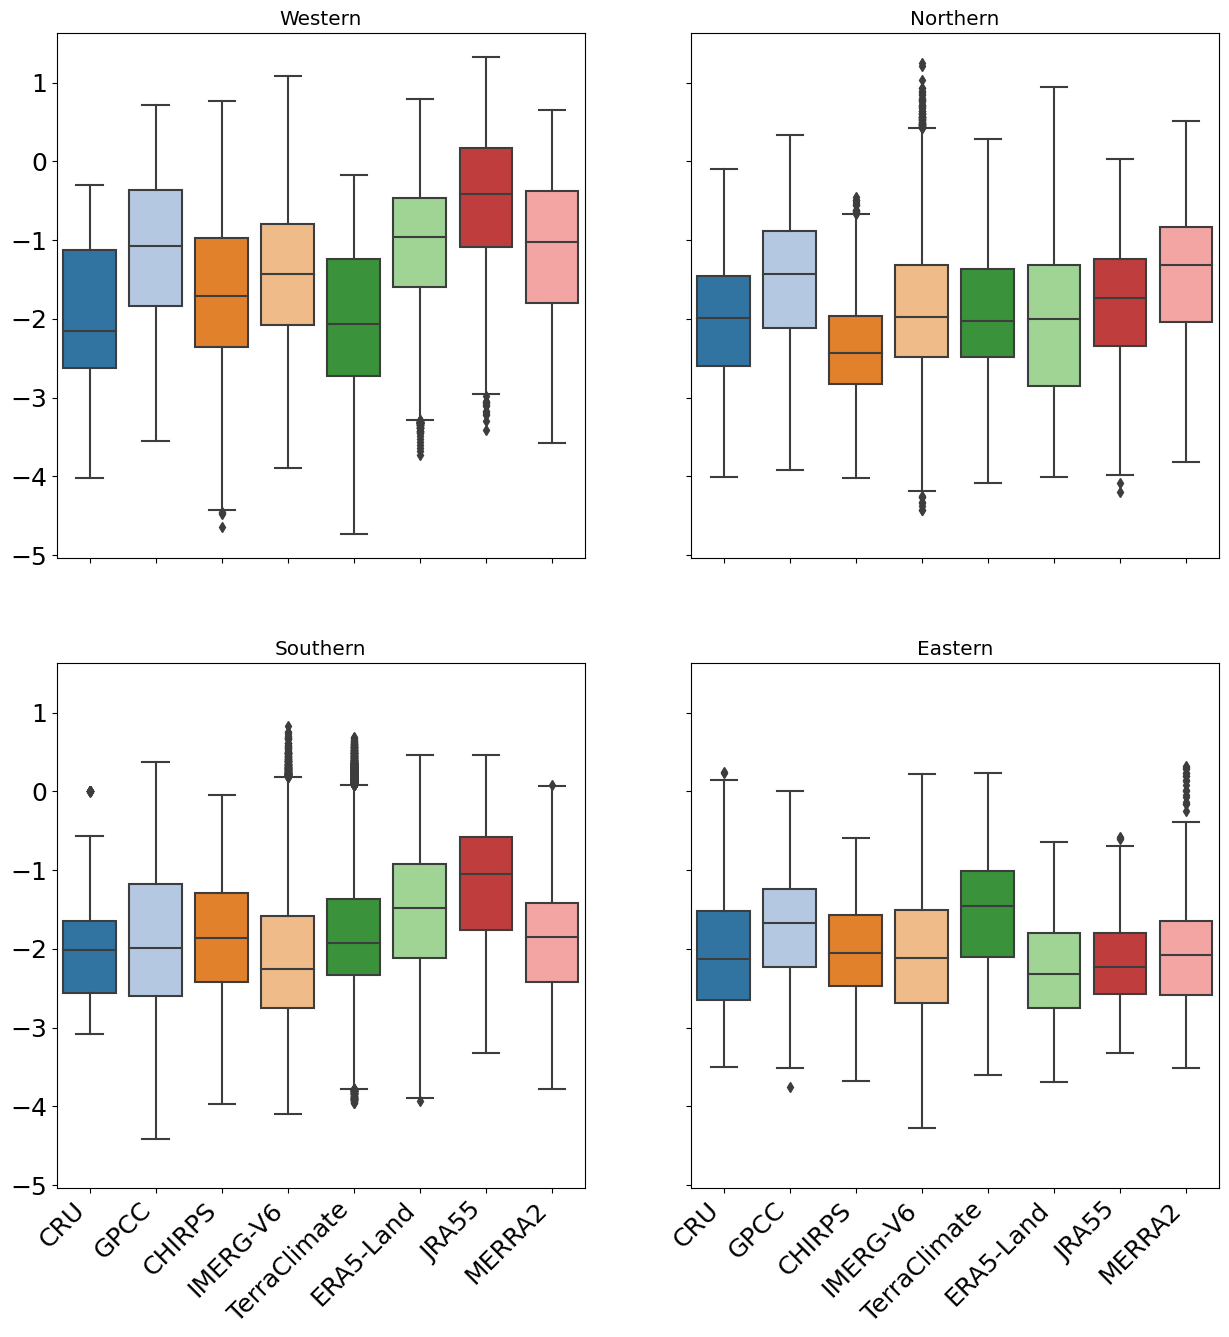

2023-10-03 12:26:39,179 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:63768', name: 0, status: running, memory: 0, processing: 0>
2023-10-03 12:26:39,278 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:63773', name: 2, status: running, memory: 0, processing: 0>
2023-10-03 12:26:39,310 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:63768'.
2023-10-03 12:26:39,319 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:63773'.
2023-10-03 12:26:44,955 - distributed.nanny - WARNING - Restarting worker
2023-10-03 16:27:10,598 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:63776', name: 3, status: running, memory: 0, processing: 0>
2023-10-03 16:27:10,609 - distributed.scheduler - 

In [25]:
#plot boxplot for each region
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True, sharex=True)
axes = axes.flatten()
#set font size as 15
plt.rcParams.update({'font.size': 12})
for i, region in enumerate(regions_list):
    ax = axes[i]
    df_region = df[df['Region']==region]
    sns.boxplot(x="Dataset", y="SPI12", data=df_region, ax=ax, palette='tab20')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(region)